This implementaion will use LTSM to predict stock prices.


In [14]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

stock_data = pd.read_csv("NVDA.csv")
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2023-10-17,440.000000,447.540009,424.799988,439.380005,439.380005,81233300
1253,2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400
1254,2023-10-19,428.109985,432.970001,418.820007,421.010010,421.010010,50123300
1255,2023-10-20,418.899994,424.700012,410.779999,413.869995,413.869995,47638100
1256,2023-10-23,412.290009,432.480011,409.450012,429.750000,429.750000,47721800


In [15]:
# check if any row or column contains invalid values
stock_data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

We will try to see the graph of the historical closing prices against time.

In [22]:
stock_data.loc[:, ['Date', 'Close']]

,Date,Close
0,2018-10-24,49.852501
1,2018-10-25,51.959999
2,2018-10-26,49.572498
3,2018-10-29,46.404999
4,2018-10-30,50.750000
...,...,...
1252,2023-10-17,439.380005
1253,2023-10-18,421.959991
1254,2023-10-19,421.010010
1255,2023-10-20,413.869995


Text(0, 0.5, 'Prices ($)')

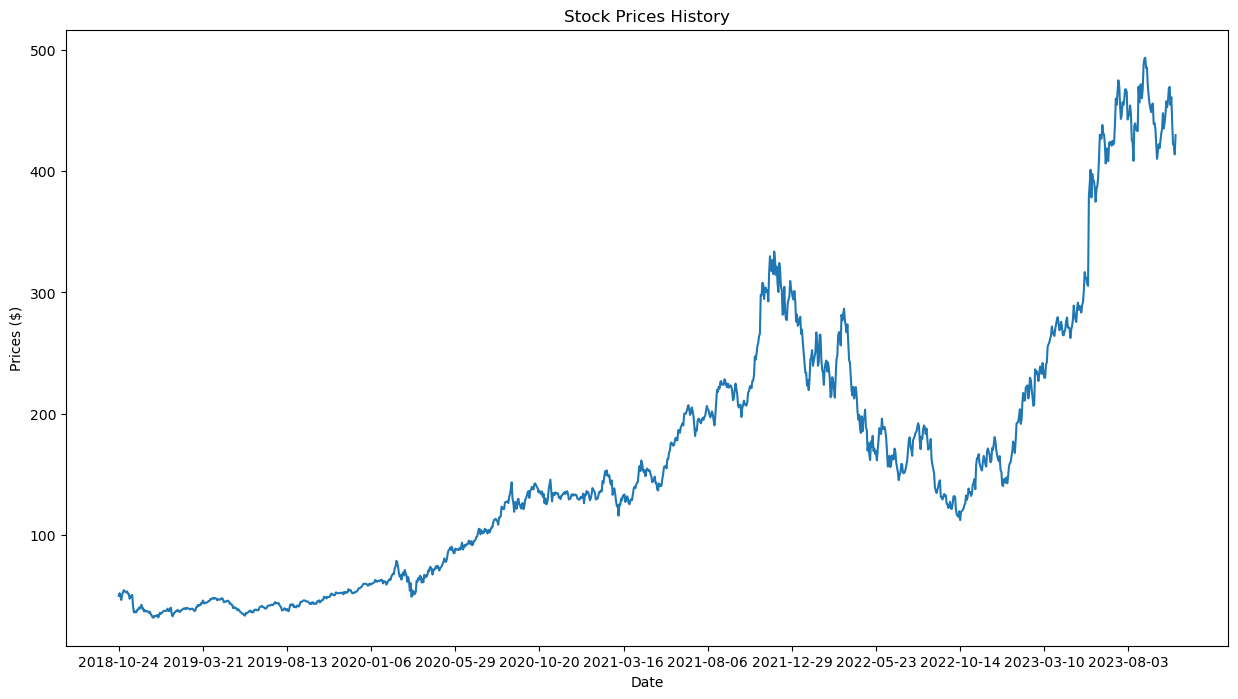

In [26]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data.loc[:, 'Date'], stock_data.loc[: , 'Close'])
plt.xticks(np.arange(0,1230,100))
plt.xlabel('Date')
plt.ylabel('Prices ($)')


We will first split the data into training and testing sets. Then attempt to normalise the data to the range of 0 to 1.

In [28]:
# We set the training set size to be 80% of total dataset
training_data_len = math.ceil(len(stock_data)* 0.8)
training_set = stock_data[['Close']].iloc[:training_data_len].values
test_set = stock_data[['Close']].iloc[training_data_len-60:].values

# Use the MinMaxScaler function to scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaler.fit_transform(training_set)

# Create a 60-days window of historical prices (i-60) as our feature data
# (x_train) and the following 60-days window as label data (y_train)
X_train = []
y_train = []

for i in range(60, training_data_len):
  X_train.append(scaled_training_set[i-60:i, 0])
  y_train.append(scaled_training_set[i, 0])

# convert array into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape X to the format (values, time-steps, 1 dimensional output)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Now we will start building the model. We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the RMSE loss function and the Adam stochastic gradient descent optimizer.

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True,
               input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 7s 48ms/step - loss: 0.0215
Epoch 2/100
30/30 [==============================] - 1s 48ms/step - loss: 0.0066
Epoch 3/100
30/30 [==============================] - 1s 48ms/step - loss: 0.0055
Epoch 4/100
30/30 [==============================] - 2s 51ms/step - loss: 0.0050
Epoch 5/100
30/30 [==============================] - 2s 53ms/step - loss: 0.0046
Epoch 6/100
30/30 [==============================] - 1s 47ms/step - loss: 0.0049
Epoch 7/100
30/30 [==============================] - 1s 48ms/step - loss: 0.0039
Epoch 8/100
30/30 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 9/100
30/30 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 10/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0042
Epoch 11/100
30/30 [==============================] - 1s 46ms/step - loss: 0.0040
Epoch 12/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0036
Epoch 13/100
30/30 [=====

Preparing the test set below.

In [35]:
# test set is the set we split at the start
scaled_test_set = scaler.fit_transform(test_set.reshape(-1, 1))

X_test = []
for i in range(60, len(scaled_test_set)):
    X_test.append(scaled_test_set[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(251, 60, 1)


Start predicting with the test set.

In [36]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 17ms/step


Now we shall visualise the result.

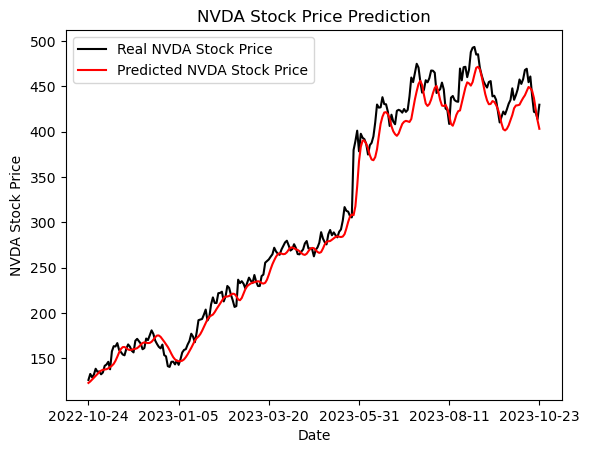

In [38]:
# Visualising the results
plt.plot(stock_data.loc[training_data_len:, 'Date'], test_set[60:, :], color = 'black', label = 'Real NVDA Stock Price')
plt.plot(stock_data.loc[training_data_len:, 'Date'], predicted_stock_price, color = 'red', label = 'Predicted NVDA Stock Price')
plt.xticks(np.arange(0,len(test_set)-60,50))
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

### Model Evaluation
We will measure the root mean squared error of the predicted values against the actual values.

In [39]:
print(predicted_stock_price[:10])
rmse = np.sqrt(np.mean(predicted_stock_price - test_set[60:, :])**2)
rmse

[[122.70538]
 [124.29301]
 [126.34872]
 [128.50566]
 [130.52473]
 [132.6384 ]
 [134.62825]
 [136.24905]
 [137.16812]
 [137.47246]]


9.717758578451816